# Node Classification on large Knowledge Graphs

## 01 Cora Dataset

 Using the `Cora` dataset consists of `2708` scientific publications classified into one of seven classes and the citation network consists of 5429 links.
 
The dictionary consists of 1433 unique words.

* Nodes = Publications (Papers, Books ...)
* Edges = Citations
* Node Features = word vectors
* 7 Labels = Pubilcation type e.g. Neural_Networks, Rule_Learning, Reinforcement_Learning, Probabilistic_Methods...

We normalize the features using torch geometric's transform functions.
 
 
 NB: This dataset was first introduced by [Yang et al. (2016)](https://arxiv.org/abs/1603.08861) as one of the datasets of the `Planetoid` benchmark suite.
 

<img src="cora_dataset.png" alt="Cora Dataset" width="400">

**Image** taken from [Veličković, P. et al. (2018)](https://personal.utdallas.edu/~fxc190007/courses/20S-7301/GAT-questions.pdf) "Graph attention networks." 


1. **Task 1:** To classify the node using the publicatoin type. Here, we are given the ground-truth labels of only a small subset of nodes, and want to infer the labels for all the remaining nodes (*transductive learning*).



## 02 Load Dataset

In [2]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

In [3]:
# load dataset
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

Processing...
Done!


In [16]:
# dataset overview

print(f'Number of graphs:', len(dataset))
print(f'Number of features', dataset.num_features)
print(f'Number of classes', dataset.num_classes)

print("="*40)

# There is only one graph in the dataset, use it as new data object
data = dataset[0]

# Gather some statistics about the graph.
print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')

# train_mask to summarize over the entries
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Is undirected: {data.is_undirected()}')

Number of graphs: 1
Number of features 1433
Number of classes 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Number of training nodes: 140
Training node label rate: 0.05
Is undirected: True


**Observations:**
- We only have a relatively small set of training nodes (20 nodes per class)
- There are binary test, train and validation masks of the size #nodes (they tell use which node can be used for which task)




In [13]:
print(data.x.shape)

torch.Size([2708, 1433])


In [15]:
# printing some of the normalized word counts for the first datapoint
data.x[0][:50]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1111, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [18]:
# show the label
# They are encoded as numerical value btw 0 to 6

data.y

tensor([3, 4, 4,  ..., 3, 3, 3])

## Example for the binary masks

<img src="binary_node.png" alt="binary_node_task" width="400">


In [19]:
print(len(data.test_mask) == data.num_nodes)
data.test_mask

True


tensor([False, False, False,  ...,  True,  True,  True])

### Example for the edge connections

In [20]:
data.edge_index.t()

tensor([[   0,  633],
        [   0, 1862],
        [   0, 2582],
        ...,
        [2707,  598],
        [2707, 1473],
        [2707, 2706]])

* We could see that node `0` is connected to node `633` and `2702` to `598`. 
**Note:** this is typically our `Adjacency Matrix`

* Now, we can build our GNN model

## 03 Graph Neural Network for Node Classification

<img src="GCN_layers.png" alt="binary_node_task" width="400">


In [21]:
# import libraries

In [22]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [36]:
# build GCN layer
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        
        
        # Initialize the layers
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = Linear(hidden_channels, dataset.num_classes)
        
        # forward layer
    def forward(self, x, edge_index):
        # First message passing layer 
        # Transformation phase
        
        x =  self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training = self.training)
        
        # Second Message Passing Layer
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p =0.5, training = self.training)
        
        # Output layer
        x = F.softmax(self.out(x), dim=1)
        return x
    
model = GCN(hidden_channels= 16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 16)
  (out): Linear(in_features=16, out_features=7, bias=True)
)


Details:

* 2 Message passing layers and  one linear output layer

* Output is 7 probailities, one for each
* Dropout is only applied in training step, but not for predictions

## 04 Training and Evaluation

In [37]:
# initialize GCN model class
model = GCN(hidden_channels = 16)

# optimizer 
learning_rate = 0.01
decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(),
                            lr = learning_rate,
                            weight_decay=decay)

#Binary class entropy

criterion = torch.nn.CrossEntropyLoss()


In [38]:
# Use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
data = data.to(device)

In [39]:
# train

def train():
    model.train()
    optimizer.zero_grad()
    
    # we use all data as input, because all nodes have features
    
    out = model(data.x, data.edge_index)
    #only use nodes with labels available for loss cal.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

# test

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    # use the class with highest probability
    pred = out.argmax(dim=1)
    # Check against ground-truth labels.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    # Derive ratio of correct predictions.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc

losses = []
for epoch in range(0, 1001):
    loss = train()
    losses.append(loss)
    if epoch % 100 == 0:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 000, Loss: 1.9461
Epoch: 100, Loss: 1.8390
Epoch: 200, Loss: 1.7540
Epoch: 300, Loss: 1.5714
Epoch: 400, Loss: 1.4263
Epoch: 500, Loss: 1.3929
Epoch: 600, Loss: 1.3959
Epoch: 700, Loss: 1.4037
Epoch: 800, Loss: 1.4021
Epoch: 900, Loss: 1.3807
Epoch: 1000, Loss: 1.3346


Visualizing the loss

/Users/anthonyekle/miniforge3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

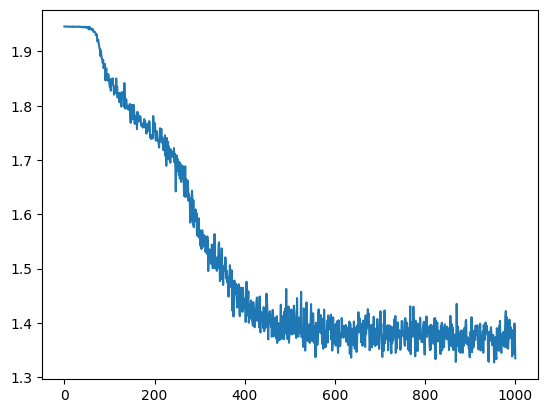

In [40]:
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses]
loss_indices = [i for i,l in enumerate(losses_float)]
plt = sns.lineplot(loss_indices, losses_float)
plt

Evaluation Matrix



In [41]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7070
